# Project 2 - Multiple Myeloma Survival


In [1]:
import pandas as pd
import missingno as msno
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor

import os

# Set white background for all plots
plt.style.use('default')
sns.set_style("white")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Create plots directory
os.makedirs("./plots", exist_ok=True)

In [2]:
df = pd.read_csv('./data/train_data.csv')

In [3]:

def create_submission_file(predictions, filename):
    """
    Create a submission file with predictions.
    
    Args:
        predictions (array-like): The predicted values for SurvivalTime.
        filename (str): The name of the output file.
    """
    # Load the sample submission to get the 'Id' column structure
    sample_submission = pd.read_csv('./data/sample_submission.csv')

    # Ensure that predictions are a single column (reshape if necessary)
    predictions = pd.Series(predictions).values
    
    # Create the submission DataFrame
    submission = pd.DataFrame(columns=sample_submission.columns) 
    submission['id'] = range(len(predictions))
    submission['0'] = predictions # Add the predictions to the 'SurvivalTime' column

    # Save the DataFrame to CSV
    os.makedirs("./results", exist_ok=True)
    submission.to_csv(f'./results/{filename}', index=False)

    print(f"File Created: ./results/{filename}")


In [4]:
def error_metric(y, y_hat, c):
    """
    Censored Mean Squared Error calculation.
    c = 0 for uncensored data points
    c = 1 for censored data points
    
    Args:
        y (array-like): True Survival Time values.
        y_hat (array-like): Predicted Survival Time values.
        c (array-like): Censoring indicators (0 for uncensored, 1 for censored).
        
    Returns:
        float: The Censored Mean Squared Error.
    """
    err = y-y_hat
    err = (1-c)*err**2 + c*np.maximum(0,err)**2
    return np.sum(err)/err.shape[0]

## Task 1 - Setting the baseline

### Task 1.1 - Data preparation and validation pipeline

**1. Missing Values Analysis**

- Visualized missing values using multiple methods (bar plot, heatmap, matrix, dendrogram)
- Created comprehensive overview of data completeness
- Identified patterns in missing data

**2. Data Cleaning**

- Dropped rows with missing `SurvivalTime` values
- Removed columns containing missing data (baseline approach)
- Excluded censored cases (where `Censored == 1`)
- Retained only complete, uncensored observations

**3. Feature Exploration**

- Visualized feature relationships using pairplot
- Analyzed correlations between Age, Gender, Stage, TreatmentType, and SurvivalTime
- Examined distribution patterns across features

**4. Data Preparation**

- Defined feature matrix (X) by dropping target and identifier columns
- Isolated target variable (y) as SurvivalTime
- Preserved censoring indicator for potential future use

**5. Validation Strategy Development**

- Implemented train/validation/test split (64%/16%/20%)
- Tested simple split approach with Linear Regression
- Implemented 5-fold cross-validation for more robust evaluation
- Compared both validation strategies (simple split vs. cross-validation)

**6. Performance Evaluation**

- Calculated MSE (Mean Squared Error) and cMSE (Censored MSE)
- Evaluated model performance on validation and test sets
- Compared cross-validation results to simple split results


/home/josec/ActiveProjects-UNI/AA-Projeto2/.venv/lib/python3.12/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


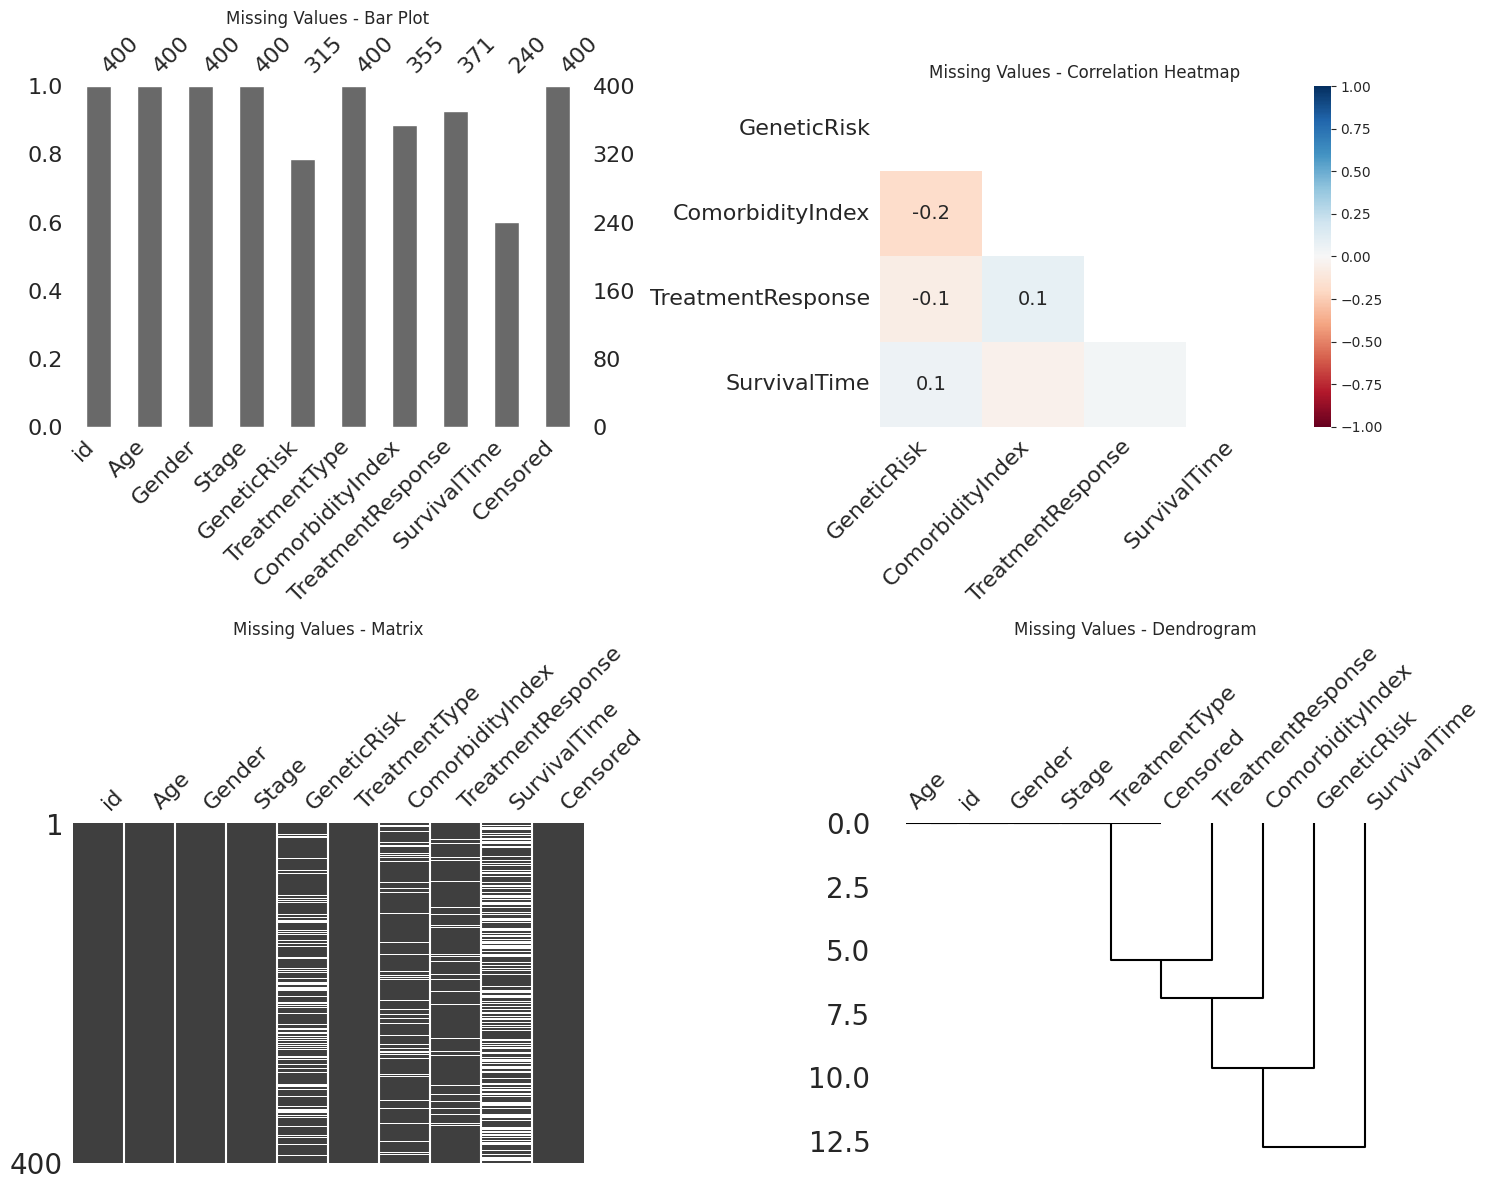

/home/josec/ActiveProjects-UNI/AA-Projeto2/.venv/lib/python3.12/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


In [5]:
# Visualize missing values using multiple missingno plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.patch.set_facecolor('white')

# Bar plot
plt.subplot(2, 2, 1)
msno.bar(df, ax=plt.gca())
plt.title('Missing Values - Bar Plot')

# Heatmap
plt.subplot(2, 2, 2)
msno.heatmap(df, ax=plt.gca())
plt.title('Missing Values - Correlation Heatmap')

# Matrix
plt.subplot(2, 2, 3)
msno.matrix(df, ax=plt.gca())
plt.title('Missing Values - Matrix')

# Dendrogram
plt.subplot(2, 2, 4)
msno.dendrogram(df, ax=plt.gca())
plt.title('Missing Values - Dendrogram')

plt.tight_layout()
plt.savefig('./plots/task1.1_missing_values_overview.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Save each plot separately
fig_bar = plt.figure(figsize=(10, 6))
fig_bar.patch.set_facecolor('white')
msno.bar(df, ax=plt.gca())
plt.title('Missing Values - Bar Plot')
plt.tight_layout()
plt.savefig('./plots/task1.1_missing_values_bar.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

fig_heatmap = plt.figure(figsize=(10, 6))
fig_heatmap.patch.set_facecolor('white')
msno.heatmap(df, ax=plt.gca())
plt.title('Missing Values - Correlation Heatmap')
plt.tight_layout()
plt.savefig('./plots/task1.1_missing_values_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

fig_matrix = plt.figure(figsize=(10, 6))
fig_matrix.patch.set_facecolor('white')
msno.matrix(df, ax=plt.gca())
plt.title('Missing Values - Matrix')
plt.tight_layout()
plt.savefig('./plots/task1.1_missing_values_matrix.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

fig_dendrogram = plt.figure(figsize=(10, 6))
fig_dendrogram.patch.set_facecolor('white')
msno.dendrogram(df, ax=plt.gca())
plt.title('Missing Values - Dendrogram')
plt.tight_layout()
plt.savefig('./plots/task1.1_missing_values_dendrogram.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

Original data points: 400
Remaining data points after cleaning: 161
Data points dropped: 239
Columns retained: ['id', 'Age', 'Gender', 'Stage', 'TreatmentType', 'SurvivalTime', 'Censored']


<Figure size 1000x600 with 0 Axes>

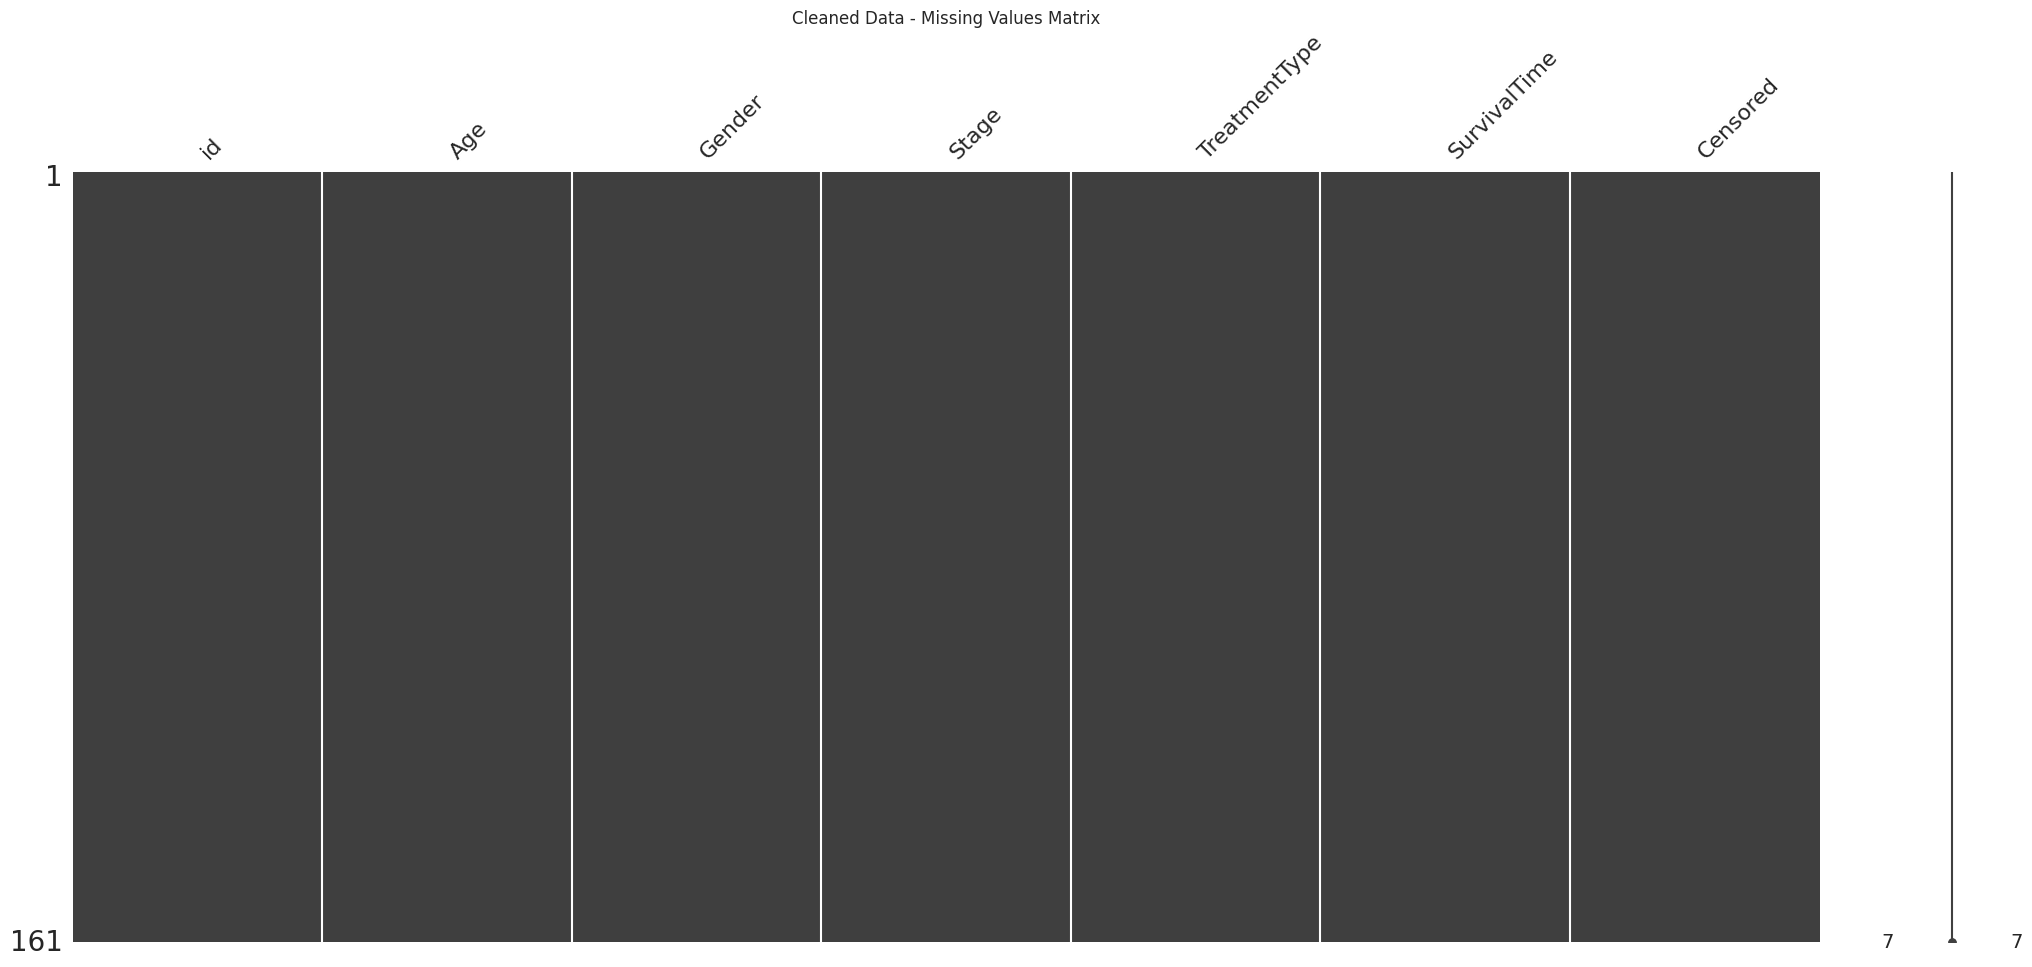

In [6]:
# Data cleaning for baseline model
# 1. Drop rows with missing 'SurvivalTime' values
df_cleaned = df[df['SurvivalTime'].notnull()].copy()

# 2. Drop columns with missing data (baseline approach)
df_cleaned = df_cleaned.dropna(axis=1)

# 3. Drop censored cases (Censored == 1) for baseline
# Censoring occurs when the exact time of an event (death/recurrence) is unknown
df_cleaned = df_cleaned[df_cleaned['Censored'] == 0]

print(f"Original data points: {df.shape[0]}")
print(f"Remaining data points after cleaning: {df_cleaned.shape[0]}")
print(f"Data points dropped: {df.shape[0] - df_cleaned.shape[0]}")
print(f"Columns retained: {list(df_cleaned.columns)}")

# Visualize cleaned data
fig = plt.figure(figsize=(10, 6))
fig.patch.set_facecolor('white')
msno.matrix(df_cleaned)
plt.title('Cleaned Data - Missing Values Matrix')
plt.savefig('./plots/task1.1_cleaned_data_matrix.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

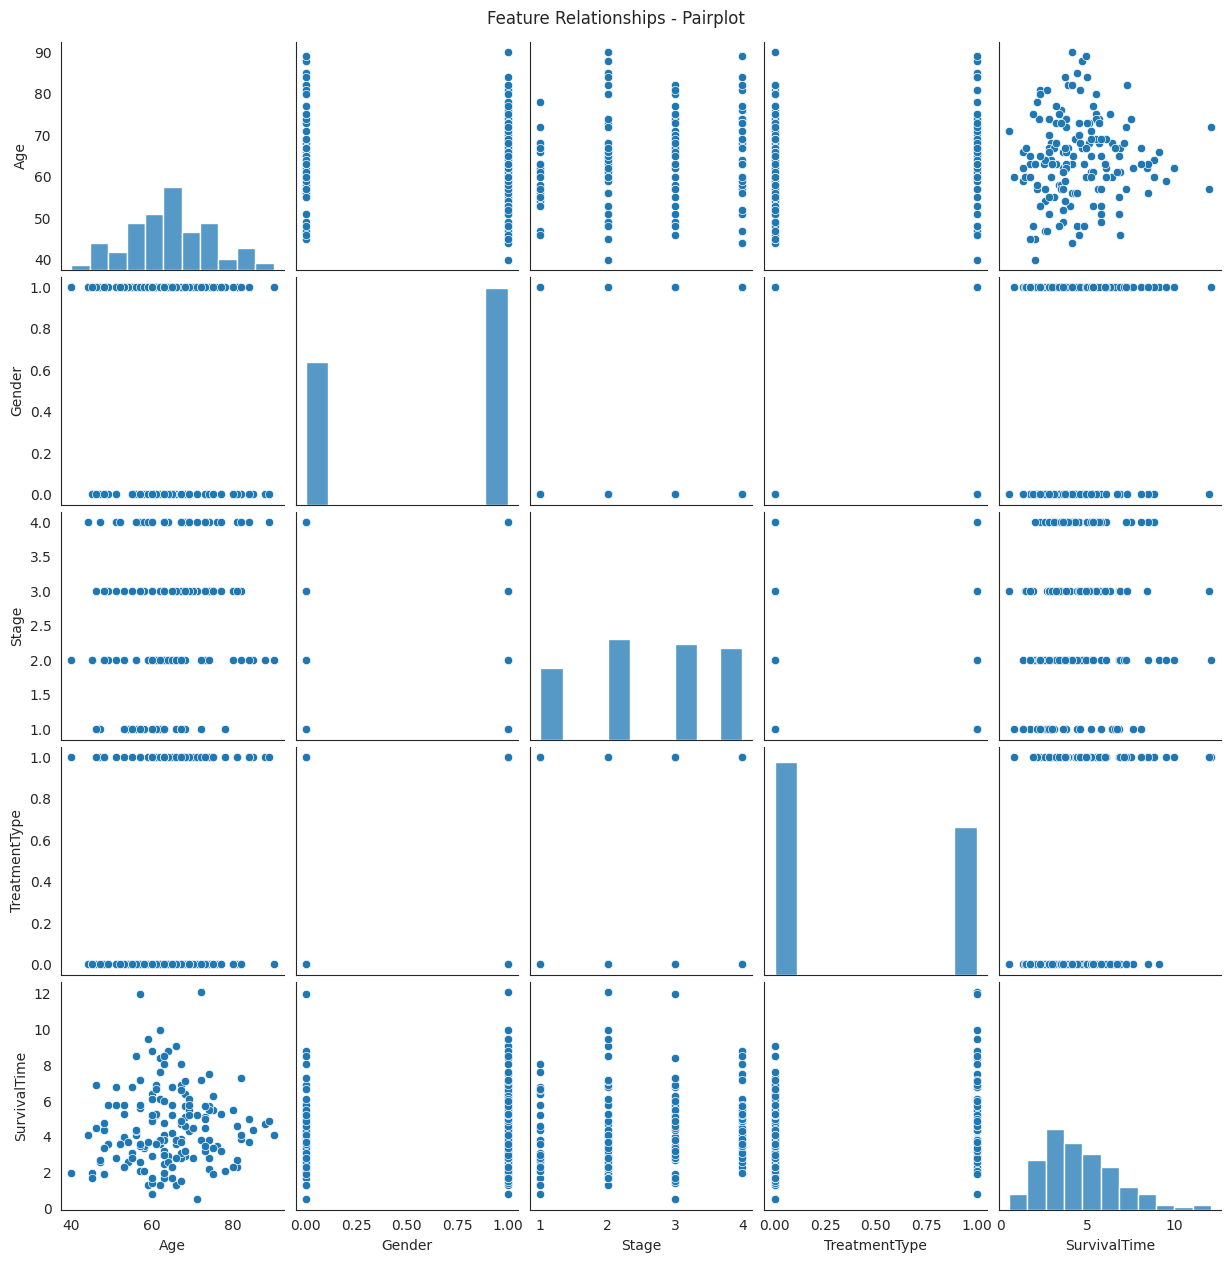

In [7]:
# Visualize feature relationships
# Note: Censored is excluded as it's a label indicator, not a predictive feature
feature_cols = ['Age', 'Gender', 'Stage', 'TreatmentType', 'SurvivalTime']
g = sns.pairplot(df_cleaned, vars=feature_cols)
g.fig.patch.set_facecolor('white')
plt.suptitle('Feature Relationships - Pairplot', y=1.01)
plt.savefig('./plots/task1.1_feature_pairplot.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [8]:
# Define the feature matrix (X) and target vector (y)
X = df_cleaned.drop(['SurvivalTime', 'Censored','id'], axis=1)  # Drop target and censoring indicator
y = df_cleaned['SurvivalTime']  # Target variable: survival time
censored = df_cleaned['Censored']  # Censoring indicator

In [9]:
# First split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: further divide train into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/X.shape[0]*100:.1f}%)")

Training set size: 102 (63.4%)
Validation set size: 26 (16.1%)
Test set size: 33 (20.5%)


In [10]:
# Simple train/validation/test approach (without cross-validation)
print("=" * 60)
print("Simple Train/Validation/Test Split Approach")
print("=" * 60)

# Train model
model_simple = LinearRegression()
model_simple.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = model_simple.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
print(f'Validation MSE: {val_mse:.4f}')

# Evaluate on test set
y_test_pred = model_simple.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'Test MSE: {test_mse:.4f}')

# Calculate cMSE (all data points are uncensored, so c=0)
test_cmse = error_metric(y_test, y_test_pred, 0)
print(f'Test cMSE: {test_cmse:.4f}')

Simple Train/Validation/Test Split Approach
Validation MSE: 3.3672
Test MSE: 5.0473
Test cMSE: 5.0473


In [11]:
# Cross-validation approach (more robust)
print("\n" + "=" * 60)
print("Cross-Validation Approach (5-fold)")
print("=" * 60)

# Train with cross-validation
model_cv = LinearRegression()
cv_scores = cross_val_score(model_cv, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_scores = -cv_scores  # Convert to positive MSE

print(f"Cross-validation MSE scores: {cv_mse_scores}")
print(f"Average CV MSE: {np.mean(cv_mse_scores):.4f} (+/- {np.std(cv_mse_scores):.4f})")

# Fit model on full dataset
model_cv.fit(X, y)
y_pred_cv = model_cv.predict(X)

# Calculate metrics
train_mse = mean_squared_error(y, y_pred_cv)
train_cmse = error_metric(y, y_pred_cv, censored)
print(f"Training MSE: {train_mse:.4f}")
print(f"Training cMSE: {train_cmse:.4f}")
print("=" * 60)


Cross-Validation Approach (5-fold)
Cross-validation MSE scores: [4.20703123 2.90729383 4.5532278  3.57321375 6.09991277]
Average CV MSE: 4.2681 (+/- 1.0747)
Training MSE: 4.0873
Training cMSE: 4.0873


Comparing the Avarage MSE Cross validation value and the MSE value simple, with Cross Validation is more efficient without Cross Validation because in cross-validation, the model is trained and validated multiple times using different splits of the dataset. This means that the model gets to train on almost all of the data, which helps the model generalize better.


In [ ]:
# Optional: Baseline model with pipeline (scaling + regression)
run_pipeline_test = bool(input("Run baseline model with pipeline? (y/n): ").lower() == "y")

if run_pipeline_test:
    print("\n" + "=" * 60)
    print("Pipeline Approach (Scaling + Linear Regression)")
    print("=" * 60)
    
    # Create fresh train/test split
    X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Build pipeline
    pipeline = make_pipeline(
        StandardScaler(),
        LinearRegression()
    )
    
    # Train and predict
    pipeline.fit(X_train_pipe, y_train_pipe)
    y_pred_pipe = pipeline.predict(X_test_pipe)
    
    # Evaluate
    mse_pipe = mean_squared_error(y_test_pipe, y_pred_pipe)
    cmse_pipe = error_metric(y_test_pipe, y_pred_pipe, 0)
    
    print(f"Pipeline MSE: {mse_pipe:.4f}")
    print(f"Pipeline cMSE: {cmse_pipe:.4f}")
    
    # Comparison with previous approaches
    print("\n" + "=" * 60)
    print("Comparison of All Approaches")
    print("=" * 60)
    print(f"Simple Split - Test MSE:  {test_mse:.4f}")
    print(f"Simple Split - Test cMSE: {test_cmse:.4f}")
    print(f"Cross-Val    - Train MSE: {train_mse:.4f}")
    print(f"Cross-Val    - Train cMSE: {train_cmse:.4f}")
    print(f"Pipeline     - Test MSE:  {mse_pipe:.4f}")
    print(f"Pipeline     - Test cMSE: {cmse_pipe:.4f}")
    print("=" * 60)
    
    show_plots = bool(input("Visualize pipeline results? (y/n): ").lower() == "y")

    if show_plots:
        fig = plt.figure(figsize=(8, 6))
        fig.patch.set_facecolor('white')
        plt.scatter(y_test_pipe, y_pred_pipe, alpha=0.6)
        plt.plot([y_test_pipe.min(), y_test_pipe.max()], 
                 [y_test_pipe.min(), y_test_pipe.max()], 'r--', lw=2)
        plt.xlabel('True Survival Time')
        plt.ylabel('Predicted Survival Time')
        plt.title('Pipeline: True vs Predicted Survival Time')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("Pipeline test skipped.")

    print("\n" + "=" * 60)
    print("Comparison of All Approaches")
    print("=" * 60)
    print(f"Simple Split - Test MSE:  {test_mse:.4f}")
    print(f"Simple Split - Test cMSE: {test_cmse:.4f}")
    print(f"Cross-Val    - Train MSE: {train_mse:.4f}")
    print(f"Cross-Val    - Train cMSE: {train_cmse:.4f}")
    print("=" * 60)

### Task 1.2 - Learn the baseline model

Train the final baseline model using cross-validation and generate predictions for submission.

**1. Pipeline Construction**

- Built baseline pipeline combining StandardScaler and Linear Regression
- Ensured feature scaling for improved model performance
- Created modular, reusable pipeline structure

**2. Cross-Validation Training**

- Performed 5-fold cross-validation for robust model evaluation
- Calculated CV MSE scores across all folds
- Computed mean and standard deviation of cross-validation performance

**3. Final Model Training**

- Fitted baseline pipeline on entire training dataset
- Generated predictions on training data
- Maximized use of available data for final model

**4. Performance Metrics**

- Calculated Training MSE (Mean Squared Error)
- Calculated Training cMSE (Censored Mean Squared Error)
- Established baseline performance benchmarks

**5. Test Predictions & Submission**

- Loaded test dataset and prepared features
- Generated predictions for test samples
- Created submission file for competition/evaluation

**6. Model Visualization**

- Created scatter plot comparing true vs predicted survival times
- Generated boxplot for distribution comparison
- Visualized model fit quality and prediction patterns
- Saved individual plots for documentation


In [ ]:
# Build baseline pipeline with scaling and Linear Regression
baseline_pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

# Perform 5-fold cross-validation
print("=" * 60)
print("Baseline Model Training with Cross-Validation")
print("=" * 60)

cv_scores = cross_val_score(baseline_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_scores = -cv_scores

print(f"CV MSE scores: {cv_mse_scores}")
print(f"Average CV MSE: {np.mean(cv_mse_scores):.4f} (+/- {np.std(cv_mse_scores):.4f})")

# Fit on entire training dataset
baseline_pipeline.fit(X, y)
y_pred_baseline = baseline_pipeline.predict(X)

# Evaluate final model
mse_baseline = mean_squared_error(y, y_pred_baseline)
cmse_baseline = error_metric(y, y_pred_baseline, censored)

print(f"\nFinal Model Performance:")
print(f"Training MSE:  {mse_baseline:.4f}")
print(f"Training cMSE: {cmse_baseline:.4f}")
print("=" * 60)

In [ ]:
# Generate predictions for test dataset and create submission file
print("\n" + "=" * 60)
print("Generating Submission File")
print("=" * 60)

# Load test data
df_test = pd.read_csv('./data/test_data.csv')

X_test_submission = df_test.drop(['id', 'GeneticRisk', 'TreatmentResponse', 'ComorbidityIndex'], axis=1)

y_test_predictions = baseline_pipeline.predict(X_test_submission)

create_submission_file(y_test_predictions, 'baseline-submission-01.csv')

print(f"Predictions generated for {len(y_test_predictions)} test samples")
print("=" * 60)

In [ ]:
# Visualize model performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('white')

# Scatter plot: True vs Predicted
axes[0].scatter(y, y_pred_baseline, alpha=0.6)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Ideal Prediction')
axes[0].set_xlabel('True Survival Time')
axes[0].set_ylabel('Predicted Survival Time')
axes[0].set_title('Baseline Model: True vs Predicted Values')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot: Distribution comparison
axes[1].boxplot([y, y_pred_baseline], tick_labels=["True Values", "Predicted Values"])
axes[1].set_ylabel('Survival Time')
axes[1].set_title('Distribution Comparison')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./plots/task1.2_baseline_model_performance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Save each plot separately
fig_scatter = plt.figure(figsize=(8, 6))
fig_scatter.patch.set_facecolor('white')
plt.scatter(y, y_pred_baseline, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Ideal Prediction')
plt.xlabel('True Survival Time')
plt.ylabel('Predicted Survival Time')
plt.title('Baseline Model: True vs Predicted Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./plots/task1.2_baseline_scatter_plot.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

fig_boxplot = plt.figure(figsize=(8, 6))
fig_boxplot.patch.set_facecolor('white')
plt.boxplot([y, y_pred_baseline], tick_labels=["True Values", "Predicted Values"])
plt.ylabel('Survival Time')
plt.title('Distribution Comparison')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('./plots/task1.2_baseline_boxplot.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

## Task 2 - Nonlinear models

### Task 2.1 - Development

Develop functions for training Polynomial Regression and k-Nearest Neighbors on the data prepared in Task 1.1, using the validation procedure determined in Task 1.1 and Task 1.2.

Select model hyperparameters (polynomial degree and k) using cross-validation for model selection.

**1. Polynomial Regression Function Development**

- Created `train_polynomial_regression()` function with hyperparameter search
- Implemented cross-validation for degree selection (testing degrees 1 to max_degree)
- Added early stopping mechanism (stops after 2 consecutive iterations without improvement)
- Returned best degree, trained model, and complete CV results dictionary

**2. k-Nearest Neighbors Function Development**

- Created `train_knn()` function with hyperparameter search
- Implemented cross-validation for k selection (testing k from 1 to max_k)
- Added early stopping mechanism for efficiency
- Returned best k value, trained model, and complete CV results dictionary

**3. Hyperparameter Selection**

- Used 5-fold cross-validation for both models
- Searched polynomial degrees from 1 to 10
- Searched k values from 1 to 20
- Tracked MSE scores with standard deviations for each hyperparameter

**4. Model Training**

- Trained Polynomial Regression with optimal degree on full dataset
- Trained k-NN Regression with optimal k on full dataset
- Generated predictions on training data for both models

**5. Performance Evaluation**

- Calculated training MSE for both models
- Calculated training cMSE for both models
- Compared performance against baseline expectations
- Documented hyperparameter selection results


In [ ]:
def train_polynomial_regression(X, y, max_degree=15, cv=5):
    """
    Trains and evaluates Polynomial Regression with cross-validation for hyperparameter selection.
    
    Args:
        X: Feature matrix
        y: Target variable
        max_degree: Maximum polynomial degree to test
        cv: Number of cross-validation folds
    
    Returns:
        best_degree: Optimal polynomial degree
        best_model: Trained model with best degree
        cv_results: Dictionary with all CV scores for each degree
    """
    cv_results = {
        'degrees': [],
        'mean_scores': [],
        'std_scores': [],
        'all_scores': []
    }
    
    best_score = -np.inf
    best_degree = None
    counter = 0
    
    print("=" * 60)
    print("Polynomial Regression - Hyperparameter Selection")
    print("=" * 60)
    
    # Search over polynomial degrees
    for degree in range(1, max_degree + 1):
        model = make_pipeline(
            StandardScaler(),
            PolynomialFeatures(degree),
            LinearRegression()
        )
        
        # Cross-validation
        scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        
        # Store results
        cv_results['degrees'].append(degree)
        cv_results['mean_scores'].append(-mean_score)
        cv_results['std_scores'].append(std_score)
        cv_results['all_scores'].append(-scores)
        
        print(f"Degree {degree}: MSE = {-mean_score:.4f} (+/- {std_score:.4f})")
        
        # Track best model
        if mean_score > best_score:
            best_score = mean_score
            best_degree = degree
            counter = 0
        else:
            counter += 1
            if counter >= 2:
                print("No improvement in 2 consecutive degrees, stopping early.")
                break

    
    print("=" * 60)
    print(f"Best Polynomial Degree: {best_degree}")
    print(f"Best Cross-Validation MSE: {-best_score:.4f}")
    print("=" * 60)
    
    # Train final model with best degree
    best_model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(best_degree),
        LinearRegression()
    )
    best_model.fit(X, y)
    
    return best_degree, best_model, cv_results

In [ ]:
def train_knn(X, y, max_k=20, cv=5):
    """
    Trains and evaluates k-Nearest Neighbors with cross-validation for hyperparameter selection.
    
    Args:
        X: Feature matrix
        y: Target variable
        max_k: Maximum number of neighbors to test
        cv: Number of cross-validation folds
    
    Returns:
        best_k: Optimal number of neighbors
        best_model: Trained model with best k
        cv_results: Dictionary with all CV scores for each k
    """
    cv_results = {
        'k_values': [],
        'mean_scores': [],
        'std_scores': [],
        'all_scores': []
    }
    
    best_score = -np.inf
    best_k = None
    counter = 0
    
    print("=" * 60)
    print("k-Nearest Neighbors - Hyperparameter Selection")
    print("=" * 60)
    
    # Search over k values
    for k in range(1, max_k + 1):
        model = make_pipeline(
            StandardScaler(),
            KNeighborsRegressor(n_neighbors=k)
        )
        
        # Cross-validation
        scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        
        # Store results
        cv_results['k_values'].append(k)
        cv_results['mean_scores'].append(-mean_score)
        cv_results['std_scores'].append(std_score)
        cv_results['all_scores'].append(-scores)
        
        print(f"k = {k:2d}: MSE = {-mean_score:.4f} (+/- {std_score:.4f})")
        
        # Track best model
        if mean_score > best_score:
            best_score = mean_score
            best_k = k
            counter = 0
        else:
            counter += 1
            if counter >= 2:
                print("No improvement in 2 consecutive k values, stopping early.")
                break
    
    print("=" * 60)
    print(f"Best k (Neighbors): {best_k}")
    print(f"Best Cross-Validation MSE: {-best_score:.4f}")
    print("=" * 60)
    
    # Train final model with best k
    best_model = make_pipeline(
        StandardScaler(),
        KNeighborsRegressor(n_neighbors=best_k)
    )
    best_model.fit(X, y)
    
    return best_k, best_model, cv_results

In [ ]:
# Train Polynomial Regression with hyperparameter selection
print("\nTraining Polynomial Regression...")
best_poly_degree, poly_model, poly_cv_results = train_polynomial_regression(X, y, max_degree=10, cv=5)

# Train k-NN Regressor with hyperparameter selection
print("\nTraining k-Nearest Neighbors...")
best_k, knn_model, knn_cv_results = train_knn(X, y, max_k=20, cv=5)

# Generate predictions on training data
y_pred_poly = poly_model.predict(X)
y_pred_knn = knn_model.predict(X)

# Calculate training metrics
mse_poly_train = mean_squared_error(y, y_pred_poly)
mse_knn_train = mean_squared_error(y, y_pred_knn)
cmse_poly_train = error_metric(y, y_pred_poly, censored)
cmse_knn_train = error_metric(y, y_pred_knn, censored)

print("\n" + "=" * 60)
print("Training Performance Summary")
print("=" * 60)
print(f"Polynomial Regression (degree={best_poly_degree}):")
print(f"  Training MSE:  {mse_poly_train:.4f}")
print(f"  Training cMSE: {cmse_poly_train:.4f}")
print(f"\nk-NN Regression (k={best_k}):")
print(f"  Training MSE:  {mse_knn_train:.4f}")
print(f"  Training cMSE: {cmse_knn_train:.4f}")
print("=" * 60)

### Task 2.2 - Evaluation

Evaluate the models developed in Task 2.1 against the baseline. Analysis backed with evidence through tables displaying different models and their metrics (max, min, mean error, and standard deviation).

**1. Comprehensive Model Comparison**

- Created comparison table with baseline, polynomial regression, and k-NN models
- Included hyperparameter configurations for each model
- Displayed min, max, mean, and standard deviation of errors
- Identified best performing model based on mean cross-validation error

**2. Hyperparameter Tuning Visualization**

- Plotted polynomial degree vs MSE with confidence intervals
- Plotted k-value vs MSE with confidence intervals
- Marked optimal hyperparameters with vertical lines
- Showed performance trends across hyperparameter ranges

**3. Model Predictions Comparison**

- Created scatter plots of true vs predicted values for all three models
- Displayed MSE on each plot for direct comparison
- Included ideal prediction line (y=x) as reference
- Generated combined and individual visualization plots

**4. Statistical Analysis**

- Computed cross-validation statistics for each model
- Analyzed variance in predictions across folds
- Compared model stability through standard deviation metrics
- Evaluated improvement over baseline model

**5. Test Set Predictions**

- Selected best performing model based on CV results
- Generated predictions for test dataset
- Created submission file for evaluation
- Documented model selection rationale

**6. Results Documentation**

- Saved all comparison plots with task-specific naming
- Generated separate plots for polynomial and k-NN tuning
- Created individual prediction visualizations for each model
- Documented complete evaluation workflow


In [ ]:
# Comprehensive model comparison table
print("\n" + "=" * 88)
print("MODEL EVALUATION - COMPARISON TABLE")
print("=" * 88)

# Collect all model results
models_data = []

# Baseline model (from Task 1.2)
baseline_cv_scores = cross_val_score(baseline_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
baseline_errors = -baseline_cv_scores
models_data.append({
    'Model': 'Baseline (Linear Regression)',
    'Hyperparameter': 'N/A',
    'Min Error': np.min(baseline_errors),
    'Max Error': np.max(baseline_errors),
    'Mean Error': np.mean(baseline_errors),
    'Std Error': np.std(baseline_errors)
})

# Polynomial Regression
poly_errors = np.array(poly_cv_results['mean_scores'])
best_poly_idx = poly_cv_results['degrees'].index(best_poly_degree)
best_poly_scores = poly_cv_results['all_scores'][best_poly_idx]
models_data.append({
    'Model': 'Polynomial Regression',
    'Hyperparameter': f'degree={best_poly_degree}',
    'Min Error': np.min(best_poly_scores),
    'Max Error': np.max(best_poly_scores),
    'Mean Error': np.mean(best_poly_scores),
    'Std Error': np.std(best_poly_scores)
})

# k-NN Regression
knn_errors = np.array(knn_cv_results['mean_scores'])
best_knn_idx = knn_cv_results['k_values'].index(best_k)
best_knn_scores = knn_cv_results['all_scores'][best_knn_idx]
models_data.append({
    'Model': 'k-NN Regression',
    'Hyperparameter': f'k={best_k}',
    'Min Error': np.min(best_knn_scores),
    'Max Error': np.max(best_knn_scores),
    'Mean Error': np.mean(best_knn_scores),
    'Std Error': np.std(best_knn_scores)
})

# Create comparison DataFrame
comparison_df = pd.DataFrame(models_data)
comparison_df = comparison_df.round(4)

print(comparison_df.to_string(index=False))
print("=" * 88)

# Identify best model
best_model_idx = comparison_df['Mean Error'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"Best Model: {best_model_name}")
print(f"Mean CV Error: {comparison_df.loc[best_model_idx, 'Mean Error']:.4f}")
print("=" * 88)

In [ ]:
# Visualize hyperparameter tuning results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.patch.set_facecolor('white')

# Polynomial Regression: Degree vs MSE
axes[0].plot(poly_cv_results['degrees'], poly_cv_results['mean_scores'], 'b-o', linewidth=2, markersize=6)
axes[0].fill_between(
    poly_cv_results['degrees'],
    np.array(poly_cv_results['mean_scores']) - np.array(poly_cv_results['std_scores']),
    np.array(poly_cv_results['mean_scores']) + np.array(poly_cv_results['std_scores']),
    alpha=0.2
)
axes[0].axvline(x=best_poly_degree, color='r', linestyle='--', label=f'Best degree = {best_poly_degree}')
axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('Cross-Validation MSE')
axes[0].set_title('Polynomial Regression - Hyperparameter Tuning')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# k-NN: k vs MSE
axes[1].plot(knn_cv_results['k_values'], knn_cv_results['mean_scores'], 'g-o', linewidth=2, markersize=6)
axes[1].fill_between(
    knn_cv_results['k_values'],
    np.array(knn_cv_results['mean_scores']) - np.array(knn_cv_results['std_scores']),
    np.array(knn_cv_results['mean_scores']) + np.array(knn_cv_results['std_scores']),
    alpha=0.2
)
axes[1].axvline(x=best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
axes[1].set_xlabel('Number of Neighbors (k)')
axes[1].set_ylabel('Cross-Validation MSE')
axes[1].set_title('k-NN Regression - Hyperparameter Tuning')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./plots/task2.1_hyperparameter_tuning.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Save individual plots separately
# Polynomial Regression plot
fig_poly = plt.figure(figsize=(8, 6))
fig_poly.patch.set_facecolor('white')
plt.plot(poly_cv_results['degrees'], poly_cv_results['mean_scores'], 'b-o', linewidth=2, markersize=6)
plt.fill_between(
    poly_cv_results['degrees'],
    np.array(poly_cv_results['mean_scores']) - np.array(poly_cv_results['std_scores']),
    np.array(poly_cv_results['mean_scores']) + np.array(poly_cv_results['std_scores']),
    alpha=0.2
)
plt.axvline(x=best_poly_degree, color='r', linestyle='--', label=f'Best degree = {best_poly_degree}')
plt.xlabel('Polynomial Degree')
plt.ylabel('Cross-Validation MSE')
plt.title('Polynomial Regression - Hyperparameter Tuning')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./plots/task2.1_polynomial_tuning.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

# k-NN plot
fig_knn = plt.figure(figsize=(8, 6))
fig_knn.patch.set_facecolor('white')
plt.plot(knn_cv_results['k_values'], knn_cv_results['mean_scores'], 'g-o', linewidth=2, markersize=6)
plt.fill_between(
    knn_cv_results['k_values'],
    np.array(knn_cv_results['mean_scores']) - np.array(knn_cv_results['std_scores']),
    np.array(knn_cv_results['mean_scores']) + np.array(knn_cv_results['std_scores']),
    alpha=0.2
)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation MSE')
plt.title('k-NN Regression - Hyperparameter Tuning')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./plots/task2.1_knn_tuning.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

In [ ]:
# Visualize predictions for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.patch.set_facecolor('white')

# Baseline predictions
axes[0].scatter(y, y_pred_baseline, alpha=0.6, color='blue')
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0].set_xlabel('True Survival Time')
axes[0].set_ylabel('Predicted Survival Time')
axes[0].set_title(f'Baseline Model\nMSE: {mse_baseline:.4f}')
axes[0].grid(True, alpha=0.3)

# Polynomial predictions
axes[1].scatter(y, y_pred_poly, alpha=0.6, color='green')
axes[1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[1].set_xlabel('True Survival Time')
axes[1].set_ylabel('Predicted Survival Time')
axes[1].set_title(f'Polynomial Regression (degree={best_poly_degree})\nMSE: {mse_poly_train:.4f}')
axes[1].grid(True, alpha=0.3)

# k-NN predictions
axes[2].scatter(y, y_pred_knn, alpha=0.6, color='orange')
axes[2].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[2].set_xlabel('True Survival Time')
axes[2].set_ylabel('Predicted Survival Time')
axes[2].set_title(f'k-NN Regression (k={best_k})\nMSE: {mse_knn_train:.4f}')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./plots/task2.2_model_predictions_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Save individual prediction plots separately
# Polynomial Regression predictions
fig_poly_pred = plt.figure(figsize=(8, 6))
fig_poly_pred.patch.set_facecolor('white')
plt.scatter(y, y_pred_poly, alpha=0.6, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('True Survival Time')
plt.ylabel('Predicted Survival Time')
plt.title(f'Polynomial Regression (degree={best_poly_degree})\nMSE: {mse_poly_train:.4f}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./plots/task2.2_polynomial_predictions.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

# k-NN predictions
fig_knn_pred = plt.figure(figsize=(8, 6))
fig_knn_pred.patch.set_facecolor('white')
plt.scatter(y, y_pred_knn, alpha=0.6, color='orange')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('True Survival Time')
plt.ylabel('Predicted Survival Time')
plt.title(f'k-NN Regression (k={best_k})\nMSE: {mse_knn_train:.4f}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./plots/task2.2_knn_predictions.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

In [ ]:
# Generate predictions for test dataset and create submission file
print("\n" + "=" * 60)
print("Generating Submission File for Task 2")
print("=" * 60)

# Load test data
df_test_task2 = pd.read_csv('./data/test_data.csv')
X_test_task2 = df_test_task2.drop(['id', 'GeneticRisk', 'TreatmentResponse', 'ComorbidityIndex'], axis=1)

# Determine which model to submit based on best CV performance
if comparison_df.loc[best_model_idx, 'Model'] == 'Polynomial Regression':
    best_predictions = poly_model.predict(X_test_task2)
    model_info = f"Polynomial Regression (degree={best_poly_degree})"
elif comparison_df.loc[best_model_idx, 'Model'] == 'k-NN Regression':
    best_predictions = knn_model.predict(X_test_task2)
    model_info = f"k-NN Regression (k={best_k})"
else:
    # If baseline is still best, use polynomial as nonlinear alternative
    best_predictions = poly_model.predict(X_test_task2)
    model_info = f"Polynomial Regression (degree={best_poly_degree})"

print(f"Best model selected: {model_info}")

# Create submission file
create_submission_file(best_predictions, 'Nonlinear-submission-01.csv')

print(f"Predictions generated for {len(best_predictions)} test samples")
print("=" * 60)

## Task 3 - Handling missing data

### Task 3.1 - Missing data imputation


In [ ]:
# df -> original dataframe
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

X_missingValues = df.drop(['SurvivalTime', 'Censored','id'], axis=1)  # Feature matrix with missing values  
y_missingValues = df['SurvivalTime']  # Target variable: survival time
#answering how many data points remain after dropping?
print(f"Remaining data points after dropping: {df.shape[0]}")


##neste exercicio para computar os missing values podemos sempre tratar consoante os que estão censored ou nao

In [ ]:
from sklearn.impute import SimpleImputer

# Create the imputer (mean imputation)
imputer = SimpleImputer(strategy='mean')

# Apply imputer to fill missing values
X_imputed_mean = imputer.fit_transform(X_missingValues)  # X is the feature matrix

y_imputed_mean = imputer.fit_transform(y_missingValues.values.reshape(-1, 1))

# # Atualizar o y com os valores imputados
# y = y_imputed_mean.flatten()

print(y_imputed_mean)

In [ ]:
from sklearn.impute import KNNImputer

# Create the KNN imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation
X_imputed_knn = knn_imputer.fit_transform(X_missingValues)  # X is the feature matrix

y_imputed_knn = knn_imputer.fit_transform(y_missingValues.values.reshape(-1, 1))


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Create the iterative imputer
iterative_imputer = IterativeImputer()

# Apply iterative imputation
X_imputed_iterative = iterative_imputer.fit_transform(X_missingValues)  # X is the feature matrix

y_imputed_iterative = iterative_imputer.fit_transform(y_missingValues.values.reshape(-1, 1))

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

model = LinearRegression()
# Função para treinar e avaliar o modelo com diferentes imputações
def evaluate_imputation(X_imputed, y):
    # Dividir os dados imputados em treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

    
    
    # Treinar o modelo
    
    model.fit(X_train, y_train)
    
    # Prever os valores
    y_pred = model.predict(X_test)
    
    # Calcular o MSE
    mse = mean_squared_error(y_test, y_pred)

   # Plotar o gráfico y vs y_hat
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values (y)')
    plt.ylabel('Predicted Values (y_hat)')
    
    plt.show()

    
    return mse

# Avaliar as três estratégias de imputação
mse_mean = evaluate_imputation(X_imputed_mean, y_imputed_mean)
mse_knn = evaluate_imputation(X_imputed_knn, y_imputed_knn)
mse_iterative = evaluate_imputation(X_imputed_iterative, y_imputed_iterative)

# Exibir os resultados
print(f'MSE com imputação por média: {mse_mean}')
print(f'MSE com imputação por KNN: {mse_knn}')
print(f'MSE com imputação iterativa: {mse_iterative}')

In [ ]:
# submission task 3.1
df_test_task3 = pd.read_csv('./data/test_data.csv')
 # quero dar drop do id
X_test_task3 = df_test_task3.drop(['id'], axis=1)

X_test_task3_imputed = imputer.fit_transform(X_test_task3)

y_test_pred1 = model.predict(X_test_task3_imputed)
print(y_test_pred1)
create_submission_file(y_test_pred1.ravel(), 'baseline-submission-3.1.csv')

### Task 3.2 - Train models that do not require imputation

In [ ]:

"""
Train models that can directly handle missing data (as requested):
- Decision Tree Regressor (tree-based method example)
- HistGradientBoostingRegressor (explicitly requested)
- CatBoostRegressor (explicitly requested)
- CatBoost with AFT for censored data (explicitly requested)
"""

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# ============================================================================
# 1. Prepare data with missing values (no imputation needed)
# ============================================================================


# Load original data with missing values
df_with_missing = pd.read_csv('./data/train_data.csv')

# Drop only rows with missing SurvivalTime (target)
df_task3_2 = df_with_missing[df_with_missing['SurvivalTime'].notnull()].copy()

# Separate features and target
X_with_missing = df_task3_2.drop(['SurvivalTime', 'Censored', 'id'], axis=1)
y_with_missing = df_task3_2['SurvivalTime']
censored_with_missing = df_task3_2['Censored']

print(f"\nDataset Information:")
print(f"Total samples: {X_with_missing.shape[0]}")
print(f"Total features: {X_with_missing.shape[1]}")
print(f"Samples with censored data: {censored_with_missing.sum()}")
print(f"Samples uncensored: {(1-censored_with_missing).sum()}")
print(f"\nMissing values per feature:")
print(X_with_missing.isnull().sum())

# ============================================================================
# 2. Decision Tree Regressor
# ============================================================================


# Note: Standard Decision Tree doesn't handle missing values natively in scikit-learn
# We use -999 as missing indicator
X_tree = X_with_missing.fillna(-999)

# Define hyperparameter grid
param_grid_tree = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search with cross-validation
print("Performing Grid Search for Decision Tree...")
tree_model = DecisionTreeRegressor(random_state=42)
grid_search_tree = GridSearchCV(
    tree_model,
    param_grid_tree,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_tree.fit(X_tree, y_with_missing)

print(f"\nBest Parameters: {grid_search_tree.best_params_}")
print(f"Best CV MSE: {-grid_search_tree.best_score_:.4f}")

# Train final model
best_tree_model = grid_search_tree.best_estimator_
y_pred_tree = best_tree_model.predict(X_tree)

# Evaluate
mse_tree = mean_squared_error(y_with_missing, y_pred_tree)
cmse_tree = error_metric(y_with_missing, y_pred_tree, censored_with_missing)

print(f"\nDecision Tree Performance:")
print(f"Training MSE:  {mse_tree:.4f}")
print(f"Training cMSE: {cmse_tree:.4f}")

# ============================================================================
# 3. HistGradientBoostingRegressor
# ============================================================================

# Define hyperparameter grid
param_grid_hist = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [100, 200, 300]
}

# Grid search with cross-validation
print("Performing Grid Search for HistGradientBoostingRegressor...")
hist_model = HistGradientBoostingRegressor(random_state=42)
grid_search_hist = GridSearchCV(
    hist_model,
    param_grid_hist,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_hist.fit(X_with_missing, y_with_missing)

print(f"\nBest Parameters: {grid_search_hist.best_params_}")
print(f"Best CV MSE: {-grid_search_hist.best_score_:.4f}")

# Train final model
best_hist_model = grid_search_hist.best_estimator_
y_pred_hist = best_hist_model.predict(X_with_missing)

# Evaluate
mse_hist = mean_squared_error(y_with_missing, y_pred_hist)
cmse_hist = error_metric(y_with_missing, y_pred_hist, censored_with_missing)

print(f"\nHistGradientBoosting Performance:")
print(f"Training MSE:  {mse_hist:.4f}")
print(f"Training cMSE: {cmse_hist:.4f}")

# ============================================================================
# 4. CatBoostRegressor (Standard)
# ============================================================================


try:
    from catboost import CatBoostRegressor
    
    # Define hyperparameter grid
    param_grid_catboost = {
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'iterations': [100, 200, 300]
    }
    
    # Grid search with cross-validation
    print("Performing Grid Search for CatBoostRegressor...")
    catboost_model = CatBoostRegressor(random_state=42, verbose=False)
    grid_search_catboost = GridSearchCV(
        catboost_model,
        param_grid_catboost,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search_catboost.fit(X_with_missing, y_with_missing)
    
    print(f"\nBest Parameters: {grid_search_catboost.best_params_}")
    print(f"Best CV MSE: {-grid_search_catboost.best_score_:.4f}")
    
    # Train final model
    best_catboost_model = grid_search_catboost.best_estimator_
    y_pred_catboost = best_catboost_model.predict(X_with_missing)
    
    # Evaluate
    mse_catboost = mean_squared_error(y_with_missing, y_pred_catboost)
    cmse_catboost = error_metric(y_with_missing, y_pred_catboost, censored_with_missing)
    
    print(f"\nCatBoost Performance:")
    print(f"Training MSE:  {mse_catboost:.4f}")
    print(f"Training cMSE: {cmse_catboost:.4f}")
    
    catboost_available = True
    
except ImportError:
    print("CatBoost not installed. Skipping CatBoost models.")
    print("Install with: pip install catboost")
    catboost_available = False

# ============================================================================
# 6. Model Comparison
# ============================================================================

print("\n" + "=" * 88)
print("MODEL COMPARISON - Task 3.2")
print("=" * 88)

comparison_task3_2 = []

# Previous models (for reference)
comparison_task3_2.append({
    'Model': 'Baseline (Task 1.2)',
    'Method': 'Drop missing data',
    'MSE': mse_baseline,
    'cMSE': cmse_baseline
})

comparison_task3_2.append({
    'Model': 'Mean Imputation (Task 3.1)',
    'Method': 'Mean imputation',
    'MSE': mse_mean,
    'cMSE': 'N/A'
})

# Task 3.2 models
comparison_task3_2.append({
    'Model': 'Decision Tree',
    'Method': 'Missing as -999',
    'MSE': mse_tree,
    'cMSE': cmse_tree
})

comparison_task3_2.append({
    'Model': 'HistGradientBoosting',
    'Method': 'Native missing support',
    'MSE': mse_hist,
    'cMSE': cmse_hist
})

if catboost_available:
    comparison_task3_2.append({
        'Model': 'CatBoost Standard',
        'Method': 'Native missing support',
        'MSE': mse_catboost,
        'cMSE': cmse_catboost
    })
    
    

df_comparison_task3_2 = pd.DataFrame(comparison_task3_2)
print("\n" + df_comparison_task3_2.to_string(index=False))
print("=" * 88)

# ============================================================================
# 7. Visualization - Predictions Comparison
# ============================================================================

print("\nGenerating visualization plots...")

# Determine number of subplots
n_models = 2 + (2 if catboost_available else 0)
n_cols = 2
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5*n_rows))
fig.patch.set_facecolor('white')

if n_rows == 1:
    axes = axes.reshape(1, -1)

axes = axes.flatten()

plot_idx = 0

# Plot 1: Decision Tree
axes[plot_idx].scatter(y_with_missing, y_pred_tree, alpha=0.5, color='brown')
axes[plot_idx].plot([y_with_missing.min(), y_with_missing.max()], 
             [y_with_missing.min(), y_with_missing.max()], 'r--', lw=2)
axes[plot_idx].set_xlabel('True Survival Time')
axes[plot_idx].set_ylabel('Predicted Survival Time')
axes[plot_idx].set_title(f'Decision Tree\nMSE: {mse_tree:.4f} | cMSE: {cmse_tree:.4f}')
axes[plot_idx].grid(True, alpha=0.3)
plot_idx += 1

# Plot 2: HistGradientBoosting
axes[plot_idx].scatter(y_with_missing, y_pred_hist, alpha=0.5, color='blue')
axes[plot_idx].plot([y_with_missing.min(), y_with_missing.max()], 
             [y_with_missing.min(), y_with_missing.max()], 'r--', lw=2)
axes[plot_idx].set_xlabel('True Survival Time')
axes[plot_idx].set_ylabel('Predicted Survival Time')
axes[plot_idx].set_title(f'HistGradientBoosting\nMSE: {mse_hist:.4f} | cMSE: {cmse_hist:.4f}')
axes[plot_idx].grid(True, alpha=0.3)
plot_idx += 1

if catboost_available:
    # Plot 3: CatBoost Standard
    axes[plot_idx].scatter(y_with_missing, y_pred_catboost, alpha=0.5, color='green')
    axes[plot_idx].plot([y_with_missing.min(), y_with_missing.max()], 
                        [y_with_missing.min(), y_with_missing.max()], 'r--', lw=2)
    axes[plot_idx].set_xlabel('True Survival Time')
    axes[plot_idx].set_ylabel('Predicted Survival Time')
    axes[plot_idx].set_title(f'CatBoost Standard\nMSE: {mse_catboost:.4f} | cMSE: {cmse_catboost:.4f}')
    axes[plot_idx].grid(True, alpha=0.3)
    plot_idx += 1
    
   

# Hide unused subplots
for idx in range(plot_idx, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('./plots/task3_2_model_predictions.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"Saved prediction plots for {plot_idx} models")

# ============================================================================
# 8. Generate Submission File
# ============================================================================

print("\n" + "=" * 80)
print("Generating Submission File for Task 3.2")
print("=" * 80)

# Load test data
df_test_task3_2 = pd.read_csv('./data/test_data.csv')
X_test_task3_2 = df_test_task3_2.drop(['id'], axis=1)
X_test_tree = X_test_task3_2.fillna(-999)

# Determine best model based on cMSE
models_results = {
    'Decision Tree': (cmse_tree, best_tree_model.predict(X_test_tree)),
    'HistGradientBoosting': (cmse_hist, best_hist_model.predict(X_test_task3_2))
}

if catboost_available:
    models_results['CatBoost Standard'] = (cmse_catboost, best_catboost_model.predict(X_test_task3_2))

# Find best model
best_model_name = min(models_results, key=lambda k: models_results[k][0])
best_cmse = models_results[best_model_name][0]
best_predictions_task3_2 = models_results[best_model_name][1]

print(f"Best model selected: {best_model_name}")
print(f"Best cMSE: {best_cmse:.4f}")
print("\nAll model cMSE scores:")
for model_name, (cmse, _) in sorted(models_results.items(), key=lambda x: x[1][0]):
    print(f"  {model_name}: {cmse:.4f}")

# Create submission file
create_submission_file(best_predictions_task3_2, 'task3_2-submission-01.csv')

print(f"\nPredictions generated for {len(best_predictions_task3_2)} test samples")
print("=" * 80)

print("\n" + "=" * 80)
print("TASK 3.2 COMPLETED!")
print("=" * 80)
print("\nSummary:")
print(f"- Decision Tree cMSE: {cmse_tree:.4f}")
print(f"- HistGradientBoosting cMSE: {cmse_hist:.4f}")
if catboost_available:
    print(f"- CatBoost Standard cMSE: {cmse_catboost:.4f}")
print(f"\n Best model: {best_model_name} (cMSE: {best_cmse:.4f})")
print("=" * 80)